# CNN_BrainTumor_Classification

# Data Preprocessing

In [1]:
#Install required packages
!pip install numpy tensorflow scikit-learn
!pip install opencv-python-headless


In [2]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

# Define the paths for training and testing data
train_dir = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Training/'
test_dir = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Testing/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Exploration

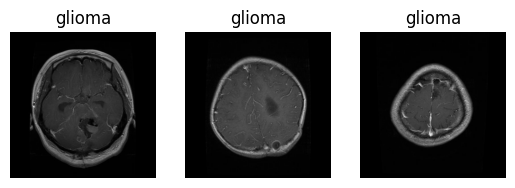

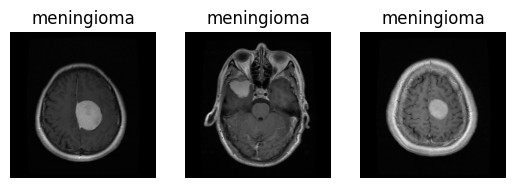

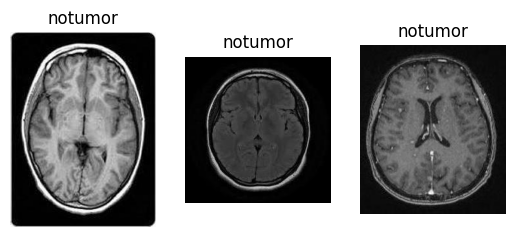

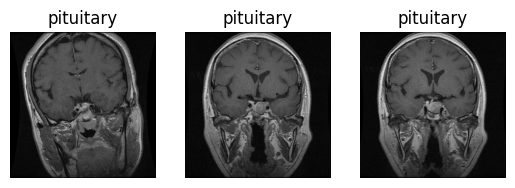

In [3]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Defining  classes for the classification task
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Function to preprocess images
def preprocess_image(img, output_size=(150, 150)):

    # Load the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask
    _, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find the largest contour, which will be the bounding box to crop
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image and resize it to the output size
    cropped_img = img[y:y+h, x:x+w]
    resized_img = cv2.resize(cropped_img, output_size)

    return img

# Function to display sample images for each class
def display_images_for_each_class(train_dir, classes, num_images=3):
    for class_name in classes:
        class_dir = os.path.join(train_dir, class_name)
        image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)][:num_images]

        for i, img_path in enumerate(image_paths):
            img = cv2.imread(img_path)
            img = preprocess_image(img)

            plt.subplot(1, num_images, i+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')

        plt.show()

display_images_for_each_class(train_dir, classes)

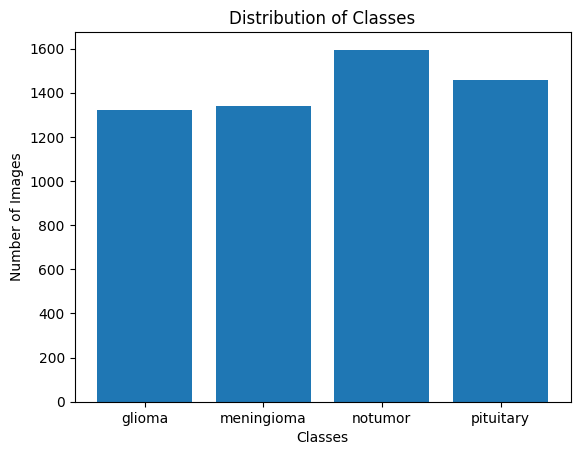

In [4]:
# Initialize a dictionary to store the counts
class_counts = {class_name: 0 for class_name in classes}

# Iterate through the class directories and count the number of images in each class
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

# Plot the distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes')
plt.show()

# Building the Model

### Define the model and constants

In [5]:
# Import TensorFlow and the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [6]:
# Define constants
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32
EPOCHS = 30
TRAIN_DIR = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Training/'
TEST_DIR = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Testing/'

# Data augmentation and normalization for training and testing dataset
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data loading and splitting into training and validation sets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

###JUST WEIGHT DECAY OF 0.01

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

# Define constants
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32
EPOCHS = 30
TRAIN_DIR = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Training/'
TEST_DIR = '/content/drive/MyDrive/Brain_tumor_MRI_dataset/Testing/'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data loading
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.3),
    Dense(4),
    Activation('softmax'),
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.05)



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


### Compile and train the model

In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



# Define a ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_brain_tumor_cnn_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Train the model with the callback
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint]
)


# Save the model
model.save('brain_tumor_cnn_model.h5')


Epoch 1/30
142/142 [==============================] - ETA: 0s - loss: 0.8640 - accuracy: 0.6213
Epoch 1: val_accuracy improved from -inf to 0.64643, saving model to best_brain_tumor_cnn_model.h5
142/142 [==============================] - 42s 261ms/step - loss: 0.8640 - accuracy: 0.6213 - val_loss: 0.9250 - val_accuracy: 0.6464
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7656
Epoch 2: val_accuracy improved from 0.64643 to 0.70893, saving model to best_brain_tumor_cnn_model.h5
142/142 [==============================] - 37s 259ms/step - loss: 0.5753 - accuracy: 0.7656 - val_loss: 0.7528 - val_accuracy: 0.7089
Epoch 3/30
142/142 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.8081
Epoch 3: val_accuracy improved from 0.70893 to 0.75268, saving model to best_brain_tumor_cnn_model.h5
142/142 [==============================] - 37s 260ms/step - loss: 0.4858 - accuracy: 0.8081 - val_loss: 0.6828 - val_accuracy: 0.7527
Epoch 4/30
142/142 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8407
Epoch 4: val_accuracy improved from 0.75268 to 0.77232, saving model to best_brain_tumor_cnn_model.h5
142/142 [==============================] - 37s 257ms/step - loss: 0.4069 - accuracy: 0.8407 - val_loss: 0.6479 - val_accuracy: 0.7723
Epoch 5/30
142/

# Model Evaluation

In [10]:
# Import the necessary libraries for evaluating the model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model

Found 1311 images belonging to 4 classes.
40/40 [==============================] - 3s 79ms/step - loss: 0.2890 - accuracy: 0.9211
Test Accuracy: 0.92
Test Loss: 0.29
41/41 [==============================] - 3s 78ms/step


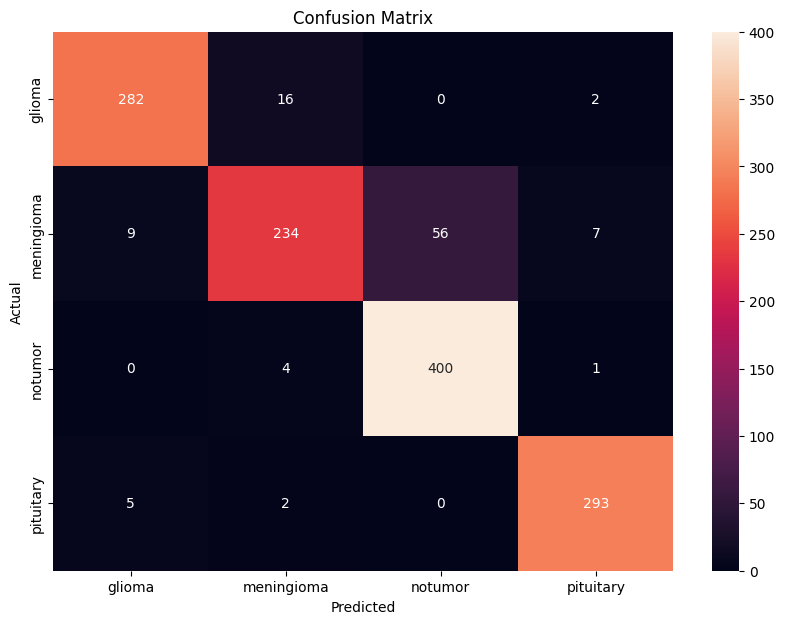

Classification Report
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.95       300
  meningioma       0.91      0.76      0.83       306
     notumor       0.88      0.99      0.93       405
   pituitary       0.97      0.98      0.97       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



In [11]:
# Load the best model
model = load_model('best_brain_tumor_cnn_model.h5')

# Setting up test data generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Evaluating the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


# Predict the values from the validation dataset
Y_pred = model.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes

#Getting the class names
target_names = list(test_generator.class_indices.keys())

#Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Using seaborn to plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Display the classification report
target_names = list(test_generator.class_indices.keys())
print('Classification Report')
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))
